In [4]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))
from config import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import time

from keras import backend as K

In [5]:
# standardization
# mean is computed only over the training data and then subtracted equally from all splits
scaler = StandardScaler().fit(X_train)
X_train = (X_train - scaler.mean_) / np.sqrt(scaler.var_)
X_test = (X_test - scaler.mean_) / np.sqrt(scaler.var_)

In [3]:
K.clear_session()
model = Sequential()
model.add(Dense(30, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
model.add(Dense(40, activation='relu', name="hidden_2"))
model.add(Dense(1, activation='sigmoid', name="op"))
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')
history = model.fit(X_train, y_train, epochs=30, batch_size=512, shuffle=True, verbose=0)
roc_auc_score(y_test, model.predict_proba(X_test))

0.8283349377566049

In [11]:
def learning_curve_nn(X, y, cv=None, train_size=None):
    lc_train = [] 
    lc_cv = []

    cut_points = np.round(train_size * X.shape[0]).astype(int)
    for cp in cut_points:
        X_sample = X.iloc[:cp]
        y_sample = y.iloc[:cp]
        train_scores = []
        cv_scores = []
        for train_idx, val_idx in cv.split(X_sample, y_sample):
            xtrain, xval = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
            ytrain, yval = y_sample.iloc[train_idx], y_sample.iloc[val_idx]

            K.clear_session()
            model = Sequential()
            model.add(Dense(30, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
            model.add(Dense(40, activation='relu', name="hidden_2"))
            model.add(Dense(40, activation='relu', name="hidden_3"))
            model.add(Dense(1, activation='sigmoid', name="op"))
            model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy')
            history = model.fit(xtrain, ytrain, epochs=30, batch_size=512, shuffle=True, verbose=0)
            
            fold_train_score = roc_auc_score(ytrain, model.predict_proba(xtrain))
            fold_cv_score = roc_auc_score(yval, model.predict_proba(xval))
#             fold_train_score = model.evaluate(xtrain, ytrain, batch_size=512)
#             fold_cv_score = model.evaluate(xval, yval, batch_size=512)

            train_scores.append(fold_train_score)
            cv_scores.append(fold_cv_score)

        lc_train.append(train_scores)
        lc_cv.append(cv_scores)
    return train_size, np.array(lc_train), np.array(lc_cv)

In [12]:
def plot_learning_curve_nn(title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel('roc_auc_score')

    train_sizes, train_scores, test_scores = learning_curve_nn(X, y, cv=cv, train_size=train_sizes)
    
    print(train_scores)
    print(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(linewidth=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[[0.55035942 0.71714456 0.60197283 0.22427209 0.44764503 0.33069779
  0.63970946 0.59020619 0.75526531 0.79919679]
 [0.7034048  0.66642263 0.72167456 0.73400077 0.75657042 0.72906191
  0.54523265 0.71847994 0.7967571  0.61676824]
 [0.77638469 0.73516187 0.78871169 0.77307471 0.6187988  0.78678072
  0.77813633 0.6739488  0.73322252 0.72780388]
 [0.80334122 0.81423671 0.72674481 0.81291194 0.80129801 0.73273157
  0.77932809 0.68173149 0.79526067 0.82785304]
 [0.81600052 0.81954787 0.80717763 0.82322041 0.81652212 0.81165664
  0.82271075 0.81275234 0.78180947 0.8129173 ]]
[[0.54076087 0.75302663 0.66491228 0.2516129  0.39130435 0.29870968
  0.56716418 0.69907407 0.70779221 0.74580645]
 [0.72425643 0.62845575 0.71582397 0.72403101 0.71688837 0.7787055
  0.48319088 0.69988074 0.77459896 0.67755928]
 [0.76292724 0.73493151 0.79643684 0.81472792 0.61426979 0.82748538
  0.76729877 0.62427721 0.66807753 0.74567983]
 [0.82248904 0.83015609 0.72255913 0.81213742 0.8100231  0.72544999
  0.7539117 

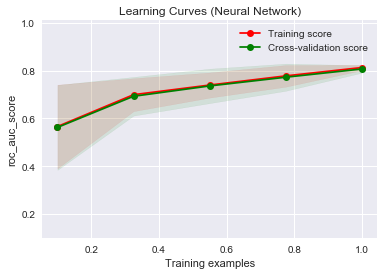

In [13]:
title = "Learning Curves (Neural Network)"
seed = 0
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)

start = time.time()
plot_learning_curve_nn(title, X_train, y_train, ylim=(0.1, 1.01), cv=cv)
print(time.time() - start)


In [6]:
args_dict = {'hidden_layer_sizes': 10, 
             'activation': 'relu', 
             'solver': 'adam', 
             'alpha': 1e-2, 
             'batch_size': 128, 
             'learning_rate_init': 0.001, 
             'max_iter': 300, 
             'shuffle': True, 
             'tol': 1e-4, 
             'verbose': False,
             'early_stopping': False,
             'validation_fraction': 0.2   # default 0.1
            }

clf = MLPClassifier(**args_dict)
title = "Learning Curves (Neural Nets)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
plot_learning_curve(clf, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, metric=roc_auc_score, n_jobs=4)